# **Importación**

Se importan y descargaran cada una de las librerias que se utilizaran

In [ ]:
!pip install rlxutils

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import gdown
from rlxutils import subplots

# **Drive**

Se conecta con el drive para descargar los archivos del mismo y cargarlos al coolab para manejarlos

In [ ]:
url1 = f'https://drive.google.com/uc?id=1EFM-jnbWsT2buCk6NjT_XAffz0oeVyLE'
url2 = f'https://drive.google.com/uc?id=1bUsh5xZo8X6Gu9vnqHsrZIyd54XkcZSv'
gdown.download(url1, 'train.csv', quiet=False)
gdown.download(url2, 'test.csv', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1EFM-jnbWsT2buCk6NjT_XAffz0oeVyLE
From (redirected): https://drive.google.com/uc?id=1EFM-jnbWsT2buCk6NjT_XAffz0oeVyLE&confirm=t&uuid=97b00723-8a6b-4cc5-be93-66d61baa162e
To: /content/train.csv
100%|██████████| 118M/118M [00:01<00:00, 68.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bUsh5xZo8X6Gu9vnqHsrZIyd54XkcZSv
To: /content/test.csv
100%|██████████| 50.1M/50.1M [00:00<00:00, 110MB/s]


'test.csv'

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# **Variables Categoricas**

In [ ]:
ccols = [i for i in df_train.columns if not i in df_train._get_numeric_data()]
print (ccols)

['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'ESTU_PAGOMATRICULAPROPIO', 'RENDIMIENTO_GLOBAL']


# **CORRELACIÓN**

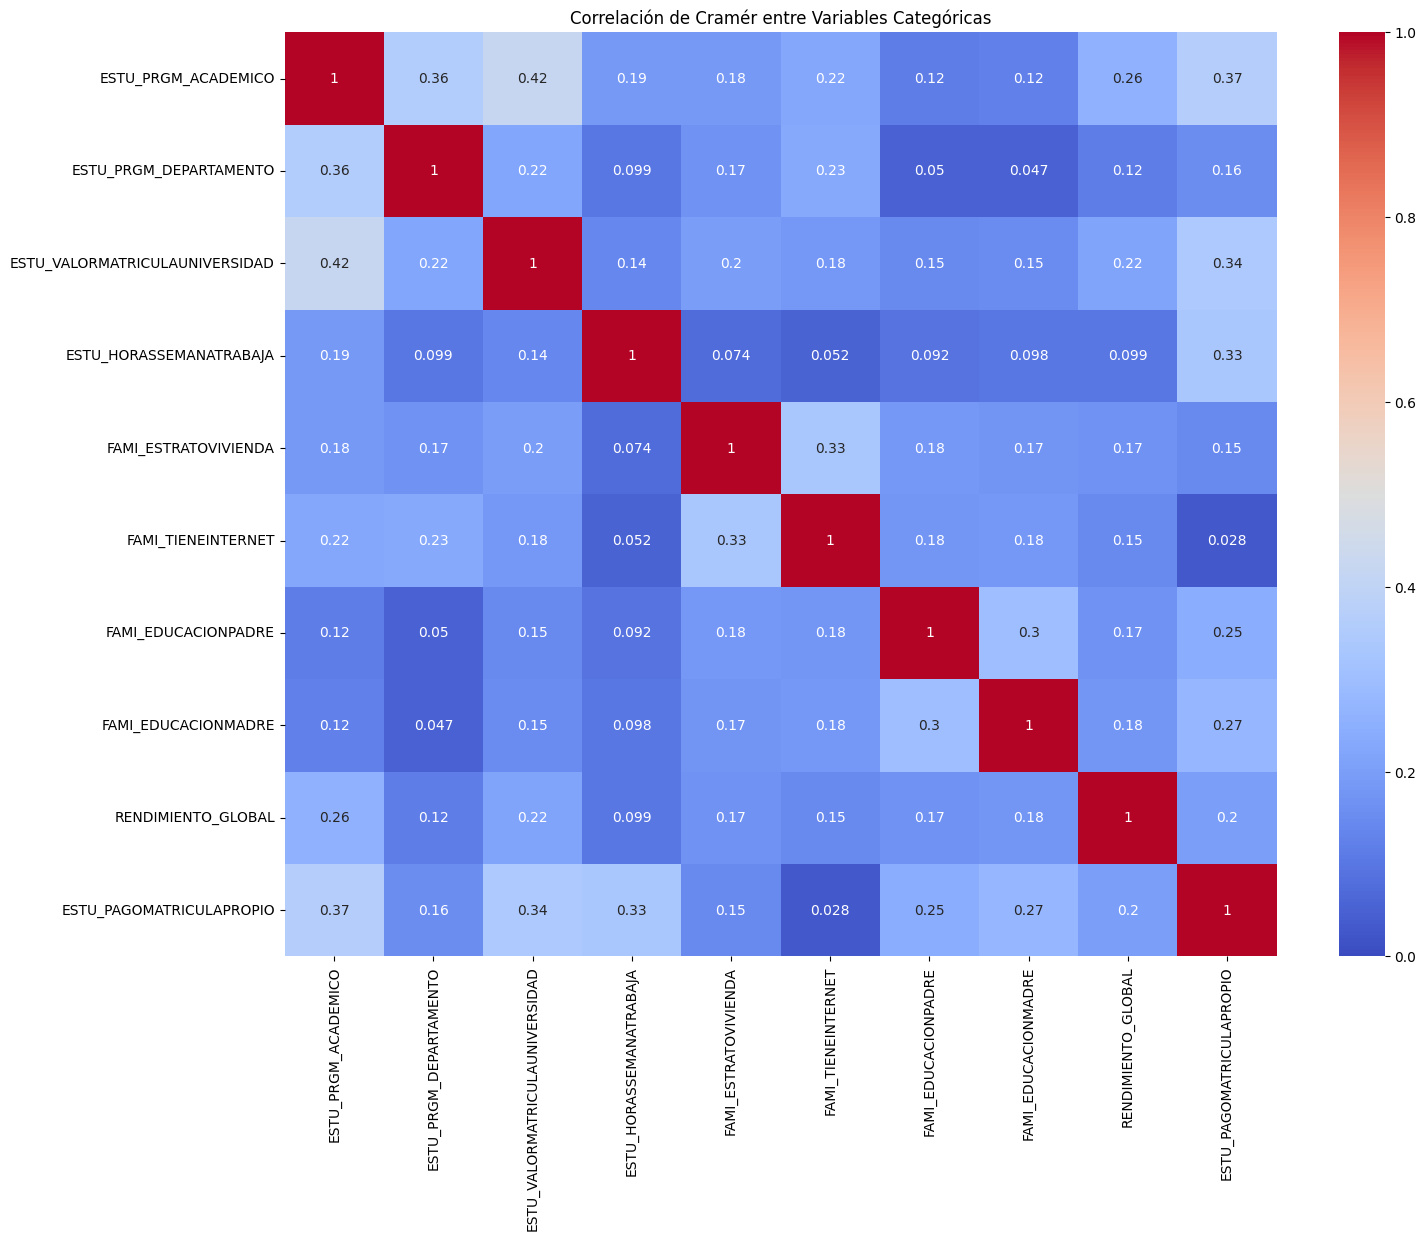

In [ ]:
# Lista de variables categóricas
categorical_columns = [
    'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD',
    'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET',
    'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'ESTU_PAGOMATRICULAPROPIO'
]

# Asegurarse de que todas las columnas categóricas estén codificadas correctamente
for col in categorical_columns:
    df_train[col] = df_train[col].astype('category')

# Función para calcular la correlación de Cramér
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Crear un DataFrame para almacenar los resultados de la correlación de Cramér
correlation_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Calcular la correlación de Cramér para cada par de variables categóricas
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            correlation = 1.0  # La correlación de una variable consigo misma es 1
        else:
            correlation = cramers_v(df_train[col1], df_train[col2])
        correlation_matrix.loc[col1, col2] = correlation

# Convertir los valores a tipo float
correlation_matrix = correlation_matrix.astype(float)

# Visualizar la matriz de correlación
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlación de Cramér entre Variables Categóricas')
plt.show()

# **Reemplazando valores perdidos**

Para los valores perdidos en cada columna se reemplazara por el valor que mas se repite



*   Para ESTU_VALORMATRICULAUNIVERSIDAD se decide reemplazar por la moda del ESTU_PRGM_ACADEMICO
*   Para FAMI_ESTRATOVIVIENDA se decide reemplazar por la moda del ESTU_VALORMATRICULAUNIVERSIDAD
*   Para ESTU_HORASSEMANATRABAJA se decide reemplazar por la moda del FAMI_ESTRATOVIVIENDA
*   Para FAMI_EDUCACIONMADRE y FAMI_EDUCACIONPADRE se decide reemplazar por la moda del FAMI_ESTRATOVIVIENDA
*   Para ESTU_PAGOMATRICULAPROPIO se decide reemplazar por la moda del ESTU_PRGM_ACADEMICO



In [ ]:
# Función para imputar valores faltantes con la moda de cada grupo
def impute_with_mode(df, group_col, target_col):
    mode_by_group = df.groupby(group_col)[target_col].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
    df[target_col] = df.apply(
        lambda row: mode_by_group[row[group_col]] if pd.isnull(row[target_col]) else row[target_col], axis=1
    )

In [ ]:
# Imputar los valores faltantes en 'ESTU_VALORMATRICULAUNIVERSIDAD' de acuerdo a 'ESTU_PRGM_ACADEMICO'
impute_with_mode(df_train, 'ESTU_PRGM_ACADEMICO', 'ESTU_VALORMATRICULAUNIVERSIDAD')
# Calcular la moda de 'ESTU_VALORMATRICULAUNIVERSIDAD'
mode_valormatricula = df_train['ESTU_VALORMATRICULAUNIVERSIDAD'].mode()[0]

# Llenar los valores faltantes en 'ESTU_VALORMATRICULAUNIVERSIDAD' con la moda general
df_train['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(mode_valormatricula, inplace=True)


<ipython-input-8-11ba56025570>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_by_group = df.groupby(group_col)[target_col].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
<ipython-input-9-5c975d5e4e0a>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(mode_valormatricula

In [ ]:
# Imputar los valores faltantes en 'ESTU_VALORMATRICULAUNIVERSIDAD' de acuerdo a 'ESTU_PRGM_ACADEMICO'
impute_with_mode(df_train, 'ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_ESTRATOVIVIENDA')
# Imputar los valores faltantes en 'ESTU_VALORMATRICULAUNIVERSIDAD' de acuerdo a 'ESTU_PRGM_ACADEMICO'
impute_with_mode(df_train, 'ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_ESTRATOVIVIENDA')
impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'ESTU_HORASSEMANATRABAJA')
impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE')
impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONMADRE')
impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET')
impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'ESTU_PAGOMATRICULAPROPIO')

In [ ]:
#comprobación de valores faltantes
pd.isnull(df_train).sum()

,0
ID,0
PERIODO,0
ESTU_PRGM_ACADEMICO,0
ESTU_PRGM_DEPARTAMENTO,0
ESTU_VALORMATRICULAUNIVERSIDAD,0
ESTU_HORASSEMANATRABAJA,0
FAMI_ESTRATOVIVIENDA,0
FAMI_TIENEINTERNET,0
FAMI_EDUCACIONPADRE,0
FAMI_EDUCACIONMADRE,0


# **Función de limpieza del dataframe**

In [ ]:
def clean_data(df):

  #reemplazando valores perdidos

  impute_with_mode(df, 'ESTU_PRGM_ACADEMICO', 'ESTU_VALORMATRICULAUNIVERSIDAD')
  mode_valormatricula = df['ESTU_VALORMATRICULAUNIVERSIDAD'].mode()[0]
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(mode_valormatricula, inplace=True)

  # Imputar los valores faltantes en 'ESTU_VALORMATRICULAUNIVERSIDAD' de acuerdo a 'ESTU_PRGM_ACADEMICO'
  impute_with_mode(df_train, 'ESTU_PRGM_ACADEMICO', 'ESTU_VALORMATRICULAUNIVERSIDAD')
  # Calcular la moda de 'ESTU_VALORMATRICULAUNIVERSIDAD'
  mode_valormatricula = df_train['ESTU_VALORMATRICULAUNIVERSIDAD'].mode()[0]

  # Llenar los valores faltantes en 'ESTU_VALORMATRICULAUNIVERSIDAD' con la moda general
  df_train['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(mode_valormatricula, inplace=True)

  # Imputar los valores faltantes en 'ESTU_VALORMATRICULAUNIVERSIDAD' de acuerdo a 'ESTU_PRGM_ACADEMICO'
  impute_with_mode(df_train, 'ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_ESTRATOVIVIENDA')
  impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'ESTU_HORASSEMANATRABAJA')
  impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE')
  impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONMADRE')
  impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET')
  impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'ESTU_PAGOMATRICULAPROPIO')


  #normalización de valores
  df['FAMI_ESTRATOVIVIENDA'].replace(['Estrato 1','Estrato 2','Estrato 3','Estrato 4','Estrato 5','Estrato 6','Sin Estrato'],[1,2,3,4,5,6,0],inplace=True)


  df["FAMI_TIENEINTERNET"] = df["FAMI_TIENEINTERNET"].replace({'Si': 1, 'No': 0})
  df["ESTU_PAGOMATRICULAPROPIO"] = df["ESTU_PAGOMATRICULAPROPIO"].replace({'Si': 1, 'No': 0})

  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['No pagó matrícula'],[0],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Menos de 500 mil'],[1],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Entre 500 mil y menos de 1 millón'],[2],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Entre 1 millón y menos de 2.5 millones'],[3],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Entre 2.5 millones y menos de 4 millones'],[4],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Entre 4 millones y menos de 5.5 millones'],[5],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Entre 5.5 millones y menos de 7 millones'],[6],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Más de 7 millones'],[7],inplace=True)

  df['ESTU_HORASSEMANATRABAJA'].replace(['0','Menos de 10 horas','Entre 11 y 20 horas','Entre 21 y 30 horas','Más de 30 horas'],[0,1,2,3,4],inplace=True)

  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].str.replace('PROFESIONAL EN ', '')

  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'INGENIERIA' if x.startswith('INGE') else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'LICENCIATURA' if x.startswith('LIC') or x.startswith('Lic') else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'ADMINISTRACION' if x.startswith('ADM')   else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CONTADURIA' if x.startswith('CONT')   else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'COMUNICACION' if x.startswith('COMU')   else x)

  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'DEPORTE' if 'DEPORT'  in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'PSICOLOGIA' if 'PSIC' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'TRABAJO SOCIAL' if 'TRABAJO SOCIAL' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'DISEÑO' if 'DISE' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'TERAPIA' if 'TERAP' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'GASTRONOMIA' if 'GASTRON' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'VETERINARIA Y ZOOTECNIA' if 'ZOOTECNIA' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'NUTRICION' if 'NUTRIC' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'MARKETING' if ( 'MARKETING' in x or 'PUBLICIDAD' in x or 'MERCAD' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'MATEMATICAS Y ESTADISTICA' if ('MATE' in x or 'ESTA' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'ARTES' if 'ARTE' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'LITERATURA' if 'LITER' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'MUSICA' if ('MUS' in x or 'MÚS' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'ECONOMIA Y NEGOCIOS' if ('ECONO' in x or 'NEG' in x or 'COME' in x or 'FIN' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CIENCIAS DE LA TIERRA' if 'GEO' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CIENCIAS AUDIOVISUALES' if ('CINE' in x or 'RADIO' in x or 'TELEV' in x or 'AUDIOV' in x or 'FOTOG' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'DERECHO' if 'DERECHO' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CIENCIAS POLITICAS' if ( 'POLIT' in x or 'POLÍT' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'INGENIERIA' if 'INGE' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'QUIMICA' if ('QUIM' in x or 'QUÍM' in x or 'QU¿M' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CONSTRUCCION' if 'CONST' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'TURISMO' if 'TURIS' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'BIBLIOTECOLOGIA' if 'BIBLIO' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'FILOSOFIA' if 'FILOS' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'FILOLOGIA' if 'FILOL' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'ODONTOLOGIA' if 'ODONTOLOG' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'BIOLOGIA Y MICROBIOLOGIA' if 'BIOL' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'ECOLOGIA' if x.startswith('ECOL')   else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'BACTERIOLOGIA' if 'BACT' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].replace('ACUICULTURA', 'ACUICUlTURA')
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CIENCIAS CULTURALES' if 'CULT' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'INSTRUMENTACION QUIRURGICA' if 'INSTRUMENTACION' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CIENCIAS MARITIMAS Y AERONAUTICAS' if ('MILIT' in x or 'NAVALES' in x or 'NAU' in x) else x)


  # Calcula el conteo de cada valor en la columna 'ESTU_PRGM_ACADEMICO'
  conteo_valores = df['ESTU_PRGM_ACADEMICO'].value_counts()

  # Obtén los valores que tienen menos de N registros
  valores_menos_de_20 = conteo_valores[conteo_valores <= 20]
  valores_menos_de_20

  # Reemplaza los valores que tienen menos de N registros con 'OTRO PROGRAMA'
  for valor in valores_menos_de_20.index:
      df.loc[df['ESTU_PRGM_ACADEMICO'] == valor, 'ESTU_PRGM_ACADEMICO'] = 'OTRO PROGRAMA'

  df = pd.get_dummies(df, columns= ["ESTU_PRGM_ACADEMICO","ESTU_PRGM_DEPARTAMENTO","FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE"])
  df = df.fillna(-1).astype(int)

  return df

In [ ]:
# Definir la longitud del conjunto de datos de entrenamiento
lentr = len(df_train)

# Extraer las columnas de origen excluyendo la columna objetivo
source_cols = [i for i in df_train.columns if i != "RENDIMIENTO_GLOBAL"]

# Concatenar los conjuntos de datos de entrenamiento y prueba
all_data = pd.concat((df_train[source_cols], df_test[source_cols]))

# Restablecer el índice del DataFrame concatenado
all_data.index = range(len(all_data))

# Limpiar los datos usando una función personalizada clean_data
all_data = clean_data(all_data)

# Separar los datos limpios de nuevo en conjuntos de datos de entrenamiento y prueba
Xtrain, ytrain = all_data.iloc[:lentr].values, df_train["RENDIMIENTO_GLOBAL"].values
Xtest = all_data.iloc[lentr:].values


print(Xtrain.shape, ytrain.shape)
print(Xtest.shape)


<ipython-input-13-8754fad86a75>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(mode_valormatricula, inplace=True)
<ipython-input-8-11ba56025570>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_by_group = df.groupby(group_col)[target_col].apply(lambda x: x.mode()[0] if not x.mode().empty 

(692500, 162) (692500,)
(296786, 162)


In [ ]:
# Importar las bibliotecas necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Definir el clasificador RandomForest
rf = RandomForestClassifier(n_estimators=75, max_depth=8, min_samples_split=3, max_features='sqrt')
print (cross_val_score(rf, Xtrain, ytrain, cv=5)) # cv=5 para validación cruzada con 5 pliegues

[0.39097473 0.3885343  0.38797834 0.38698917 0.38740072]


# **Entrenar el modelo**

In [ ]:
rf.fit(Xtrain, ytrain)
# Hacer predicciones con los datos de prueba
preds_ts = rf.predict(Xtest)
preds_ts

array(['bajo', 'bajo', 'alto', ..., 'alto', 'alto', 'alto'], dtype=object)

# **Creación de dataframe de submission con las columnas ID y RENDIMIENTO_GLOBAL**

In [ ]:
submission = pd.DataFrame([df_test.ID, pd.Series(preds_ts, name="RENDIMIENTO_GLOBAL")]).T
submission.head()

submission.to_csv("archivo_final.csv",index=False)

print("****** EJECUCIÓN FINALIZADA *******")

****** EJECUCIÓN FINALIZADA *******
